In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [360]:
mf_data = pd.read_csv("midfielder_data.csv")
gk_data = pd.read_csv("goalkeeper_data.csv")
df_data = pd.read_csv("defender_data.csv")
at_data = pd.read_csv("attacker_data.csv")

In [255]:
#do some renaming
mf_data.columns = mf_data.columns.str.replace('.', '_')
mf_data.columns = mf_data.columns.str.replace('___', '_')
mf_data.columns = mf_data.columns.str.replace(' ', '_')

gk_data.columns = gk_data.columns.str.replace('.', '_')
gk_data.columns = gk_data.columns.str.replace('___', '_')
gk_data.columns = gk_data.columns.str.replace(' ', '_')

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_8271/663454476.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mf_data.columns = mf_data.columns.str.replace('.', '_')
/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_8271/663454476.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gk_data.columns = gk_data.columns.str.replace('.', '_')


In [298]:
#sns.lineplot(data = train, x = "h", y = "Value")
at_data.query("`Name` == 'A. Griezmann'")

,Name,Age,Overall.rating,Potential,Years Left,field_position,Value,Wage,Skill.moves,Total.attacking,Total.skill,Total.movement,Total.power,Total.mentality,Weak.foot
5,A. Griezmann,27,89,89,4.0,Attacker,71000000.0,140000.0,4,426,425,435,402,381,3


In [291]:
at_data.Name

'A. Griezmann'

In [257]:
mf_data = mf_data.drop(["field_position"], axis = 1)
mf_data = mf_data.drop(["Name"], axis = 1)
mf_data = mf_data.dropna() #drops NA Values

In [258]:
from sklearn.model_selection import train_test_split
mf_train, mf_test = train_test_split(mf_data, test_size = .2, shuffle = True)


#getting the target vector
X_train_mf = mf_train.drop(["Value"], axis = 1)
y_train_mf = mf_train["Value"]

X_test_mf = mf_test.drop(["Value"], axis = 1)
y_test_mf = mf_test["Value"]

In [259]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#normalized_X_train = sc.fit_transform(X_train)

In [260]:
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_mf, y_train_mf)
reg.score(X_test_mf,y_test_mf)

0.8574553828329162

In [261]:
#reg.predict(X_test)

In [262]:
#make a new dataframe with player and predicted market value

In [263]:
#X_test

In [264]:
gk_data = gk_data.drop(["field_position"], axis = 1)
gk_data = gk_data.drop(["Name"], axis = 1)
gk_data = gk_data.dropna() #drops NA Values

In [265]:
from sklearn.model_selection import train_test_split
gk_train, gk_test = train_test_split(gk_data, test_size = .2, shuffle = True)


#getting the target vector
X_train_gk = gk_train.drop(["Value"], axis = 1)
y_train_gk = gk_train["Value"]

X_test_gk = gk_test.drop(["Value"], axis = 1)
y_test_gk = gk_test["Value"]

In [266]:
from sklearn.linear_model import LinearRegression

reg2 = LinearRegression().fit(X_train_gk, y_train_gk)
reg2.score(X_test_gk,y_test_gk)

0.9049225407525437

In [267]:
#mf_data #could use more specifics

In [268]:
df_data = df_data.drop(["field_position"], axis = 1)
df_data = df_data.drop(["Name"], axis = 1)
df_data = df_data.dropna() #drops NA Values

In [269]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_data, test_size = .2, shuffle = True)


#getting the target vector
X_train_df = df_train.drop(["Value"], axis = 1)
y_train_df = df_train["Value"]

X_test_df = df_test.drop(["Value"], axis = 1)
y_test_df = df_test["Value"]

In [270]:

from sklearn.linear_model import LinearRegression

reg3 = LinearRegression().fit(X_train_df, y_train_df)
reg3.score(X_test_df,y_test_df)

0.8300071045277817

In [369]:
#Testing
at_data = pd.read_csv("attacker_data.csv")
at_data = at_data.dropna()

In [402]:
from sklearn.model_selection import train_test_split
at_train, at_test = train_test_split(at_data, test_size = .2, shuffle = True)

final_at = pd.DataFrame(at_test, columns = ["Name"])
final_at["actual"] = at_test['Value'].copy()

#final_at = final_at["actual"] = at_test["Value"] 

#getting the target vector
X_train_at = at_train.drop(["Value"], axis = 1)
y_train_at = at_train["Value"]

X_test_at = at_test.drop(["Value"], axis = 1)
y_test_at = at_test["Value"]

In [403]:
final_at

,Name,actual
947,J. Pohjanpalo,4200000
1624,L. Mousset,2400000
522,D. Quintero,6500000
1434,D. Solanke,3500000
793,M. Vlap,6000000
...,...,...
545,Rubén Castro,1900000
82,M. Balotelli,23500000
153,Mariano,16000000
1104,Josué da Feira,3400000


In [398]:
X_test_at

,Name,Age,Overall.rating,Potential,Years Left,field_position,Wage,Skill.moves,Total.attacking,Total.skill,Total.movement,Total.power,Total.mentality,Weak.foot
984,G. Sunu,27,72,72,1,Attacker,10000,3,338,326,350,335,309,3
763,Salvi Sánchez,27,73,73,1,Attacker,10000,3,305,343,407,301,294,3
39,Iago Aspas,30,84,84,4,Attacker,50000,3,408,391,409,364,345,3
1700,Isma López B,28,69,69,2,Attacker,6000,3,283,323,383,343,309,3
1117,D. Lainez,18,72,85,5,Attacker,8000,3,299,326,421,291,286,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,M. Pisano,26,73,73,4,Attacker,3000,4,301,358,401,301,273,3
1525,M. Robak,35,70,70,0,Attacker,5000,3,297,285,316,346,319,3
805,E. Mor,20,73,82,3,Attacker,15000,4,309,300,413,302,264,3
173,Elkeson,28,79,79,3,Attacker,30000,4,372,375,393,391,364,4


In [404]:
X_train_at = X_train_at.drop(["field_position"], axis = 1)
X_train_at = X_train_at.drop(["Name"], axis = 1)



X_test_at = X_test_at.drop(["field_position"], axis = 1)
X_test_at = X_test_at.drop(["Name"], axis = 1)

In [405]:

from sklearn.linear_model import LinearRegression

reg4 = LinearRegression().fit(X_train_at, y_train_at)
reg4.score(X_test_at,y_test_at)
predictions = reg4.predict(X_test_at)

In [407]:
final_at["predictions"] = predictions

In [408]:
pd.options.display.float_format = '{:.0f}'.format

In [409]:
final_at

,Name,actual,predictions
947,J. Pohjanpalo,4200000,6838106
1624,L. Mousset,2400000,4336576
522,D. Quintero,6500000,5710074
1434,D. Solanke,3500000,4658849
793,M. Vlap,6000000,6466678
...,...,...,...
545,Rubén Castro,1900000,2963545
82,M. Balotelli,23500000,23974132
153,Mariano,16000000,29194111
1104,Josué da Feira,3400000,3064473


In [ ]:
#should we focus on optimizing this model for rn?
#or
#add real player stats (not collected yet) and try to switch out target vector to tranfermrkt.com values (still subjective, not collected)
###just testing how good fifa's predictions are compared to tranfsermrkt.com; ehh

#I THINK THIS IS THE MOVE; #COSIGNED BY PHIL + DO MACHINE LEARNY STUFF
#add (merge) club data (collected) and try to predict transfer fees (not collected) for that year; not every player has tranfer fees (target vector will be smaller than #samples)
#do we have to tailor make the test set to only include players that have tranfer fees?? eh
#use all players for training, but only players with tranfer fees for testing
#gonna be hard to get tranfer fees on here



#250 available, but we have over 1400 players in our 


#misc: is it cheating to train multiple times and choose the training set that produces best parameter vector (based on score on validation test)


#completely different problem but it's ok

#Do some experimentation stuff w/ different models, etc.s



<AxesSubplot: xlabel='Years_Left', ylabel='Value'>

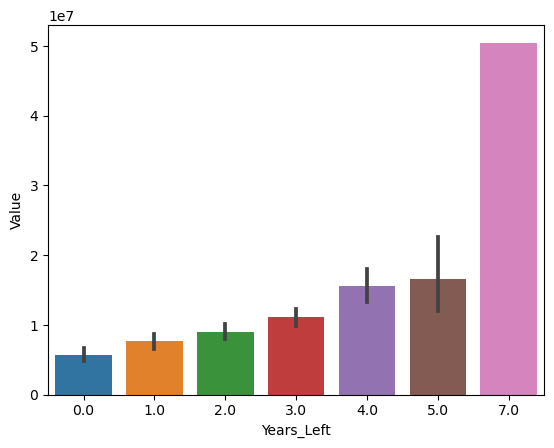

In [197]:
sns.barplot(data = train, x = "Years_Left", y = "Value")

<AxesSubplot: xlabel='Skill_moves', ylabel='Value'>

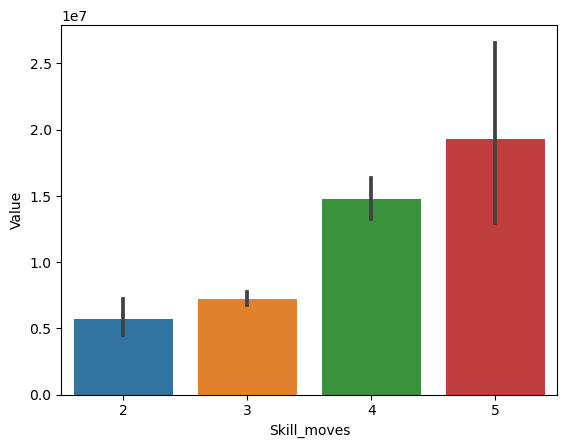

In [198]:
sns.barplot(data = train, x = "Skill_moves", y = "Value")

<AxesSubplot: xlabel='Overall_rating', ylabel='Value'>

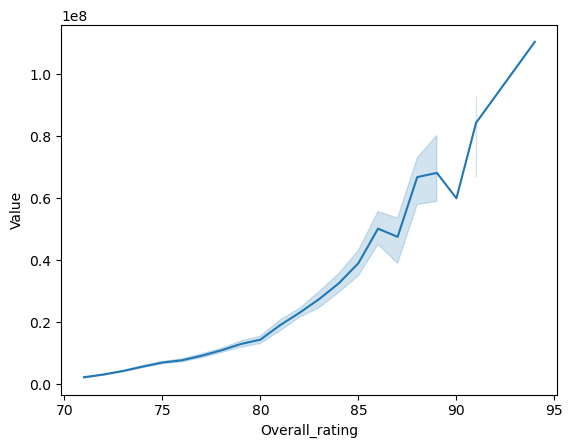

In [196]:
sns.lineplot(data = train, x = "Overall_rating", y = "Value")